In [8]:
# ==========================================================
# BLOCCO 1 ✅ DEFINITIVO
# Lettura dataset compressi + Preprocessing etichette
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

print("📂 Caricamento dataset compressi...")

# === Lettura file .npz generato nel BLOCCO 11 ===
data_npz = np.load(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\train_test_bal.npz", allow_pickle=True)

# === Estrazione dei dataset ===
X_train = data_npz["X_train"]
X_test = data_npz["X_test"]
y_train = data_npz["y_train"]
y_test = data_npz["y_test"]

# === Dataset bilanciato opzionale ===
X_train_bal = data_npz["X_train_bal"]
y_train_bal = data_npz["y_train_bal"]

print("✅ Dataset caricati con successo dal file .npz\n")

# === Conversione etichette (da stringhe a numeri) ===
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_train_bal_enc = le.transform(y_train_bal)

# === Info riepilogative ===
print("📊 Dimensioni:")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_test : {X_test.shape}  | y_test : {y_test.shape}")
print(f"X_train_bal: {X_train_bal.shape} | y_train_bal: {y_train_bal.shape}")

print("\n🔢 Classi trovate:", list(le.classes_))
print("Numero classi:", len(le.classes_))

# === Verifica che tutto sia numerico ===
X_train_used = X_train_bal if X_train_bal is not None else X_train
print("\nTipi delle colonne in X_train_used:")
print(pd.DataFrame(X_train_used).dtypes.value_counts())

non_numeric = [
    col for col in pd.DataFrame(X_train_used).columns
    if not np.issubdtype(pd.DataFrame(X_train_used)[col].dtype, np.number)
]
print("\nColonne non numeriche:", non_numeric)

📂 Caricamento dataset compressi...
✅ Dataset caricati con successo dal file .npz

📊 Dimensioni:
X_train: (245672, 16) | y_train: (245672,)
X_test : (61418, 16)  | y_test : (61418,)
X_train_bal: (38448, 16) | y_train_bal: (38448,)

🔢 Classi trovate: ['Discovery', 'Reconnaissance', 'Resource Development']
Numero classi: 3

Tipi delle colonne in X_train_used:
float32    16
Name: count, dtype: int64

Colonne non numeriche: []


In [15]:
# ==========================================================
# BLOCCO 2 ✅ Random Forest (train bilanciato) con monitoraggio fold per fold e griglia estesa
# ==========================================================
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, 
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize

print("🏗️ Addestramento Random Forest (TRAIN BILANCIATO) con griglia estesa e monitoraggio fold per fold...\n")

# ==========================================================
# 1️⃣ Impostazione base del modello e della griglia iperparametri
# ==========================================================
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # più alberi per stabilità

param_grid = {
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

param_combinations = list(product(
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf'],
    param_grid['max_features'],
    param_grid['bootstrap']
))

print(f"🔍 Inizio GridSearch manuale su {len(param_combinations)} combinazioni (~{len(param_combinations)*5} fit fold per fold)...\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_score = -np.inf
best_params = None
results = []

# ==========================================================
# 2️⃣ Ciclo combinazioni e monitoraggio training fold per fold
# ==========================================================
for i, (max_depth, min_split, min_leaf, max_feat, boot) in enumerate(param_combinations, 1):
    params = {
        'max_depth': max_depth,
        'min_samples_split': min_split,
        'min_samples_leaf': min_leaf,
        'max_features': max_feat,
        'bootstrap': boot
    }
    print(f"⚙️ Combinazione {i}/{len(param_combinations)} → {params}")
    start = time.time()
    
    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_bal, y_train_bal), 1):
        X_tr, X_val = X_train_bal[train_idx], X_train_bal[val_idx]
        y_tr, y_val = y_train_bal[train_idx], y_train_bal[val_idx]

        model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            **params
        )
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, average='macro')
        fold_scores.append(score)
        print(f"   📈 Fold {fold}/5 → F1 = {score:.4f}")

    mean_score = np.mean(fold_scores)
    elapsed = time.time() - start
    print(f"✅ Combinazione {i} completata in {elapsed:.2f}s | F1 medio = {mean_score:.4f}\n")

    results.append((params, mean_score))
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"🏁 GridSearch completata. Miglior F1 = {best_score:.4f}")
print(f"🏆 Migliori iperparametri trovati: {best_params}\n")

# ==========================================================
# 3️⃣ Training finale con i migliori parametri
# ==========================================================
best_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    **best_params
)
best_rf.fit(X_train_bal, y_train_bal)

# ==========================================================
# 4️⃣ Metriche dettagliate (train e test)
# ==========================================================
def print_metrics(y_true, y_pred, name, classes):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n📊 Metriche sul {name} set:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    for i, cls in enumerate(classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Specificità classe '{cls}': {spec:.4f}")
    return f1

y_train_pred = best_rf.predict(X_train_bal)
y_test_pred = best_rf.predict(X_test)

# Convertiamo tutte le etichette in stringhe per evitare il ValueError
y_train_bal_str = y_train_bal.astype(str)
y_test_str = y_test.astype(str)
classes_str = np.unique(np.concatenate([y_train_bal_str, y_test_str]))

train_f1 = print_metrics(y_train_bal_str, y_train_pred.astype(str), "TRAIN", classes_str)
test_f1 = print_metrics(y_test_str, y_test_pred.astype(str), "TEST", classes_str)

# ==========================================================
# 5️⃣ Analisi over/underfitting
# ==========================================================
gap_f1 = train_f1 - test_f1
if gap_f1 > 0.05:
    print(f"\n⚠️ Possibile OVERFITTING: gap F1 train-test = {gap_f1:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile UNDERFITTING: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato, nessun evidente overfitting/underfitting")


🏗️ Addestramento Random Forest (TRAIN BILANCIATO) con griglia estesa e monitoraggio fold per fold...

🔍 Inizio GridSearch manuale su 32 combinazioni (~160 fit fold per fold)...

⚙️ Combinazione 1/32 → {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
   📈 Fold 1/5 → F1 = 0.9997
   📈 Fold 2/5 → F1 = 1.0000
   📈 Fold 3/5 → F1 = 0.9999
   📈 Fold 4/5 → F1 = 1.0000
   📈 Fold 5/5 → F1 = 0.9999
✅ Combinazione 1 completata in 36.22s | F1 medio = 0.9999

⚙️ Combinazione 2/32 → {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
   📈 Fold 1/5 → F1 = 0.9997
   📈 Fold 2/5 → F1 = 1.0000
   📈 Fold 3/5 → F1 = 1.0000
   📈 Fold 4/5 → F1 = 1.0000
   📈 Fold 5/5 → F1 = 1.0000
✅ Combinazione 2 completata in 79.62s | F1 medio = 0.9999

⚙️ Combinazione 3/32 → {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}
   📈 Fold 1/5 → F1 = 0.9997
  

📊 Generazione grafici e visualizzazioni avanzate per Random Forest bilanciata...



c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


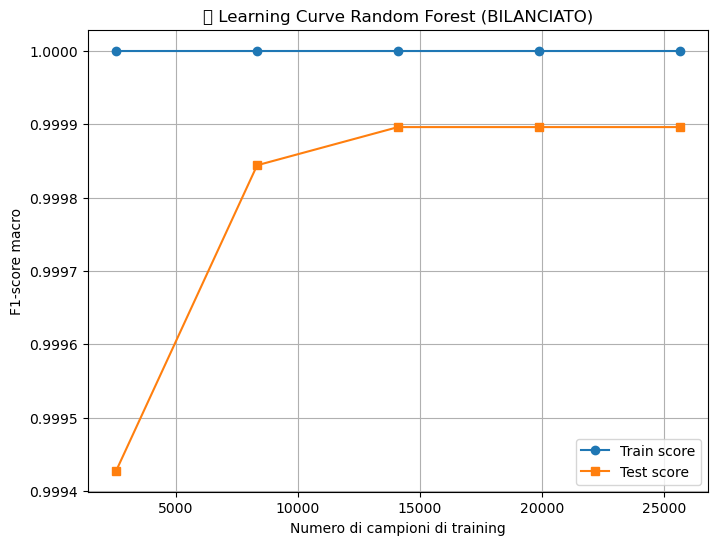

<Figure size 800x600 with 0 Axes>

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


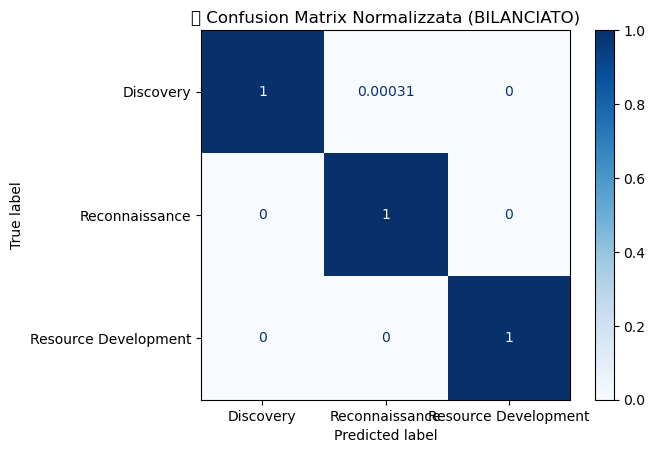

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


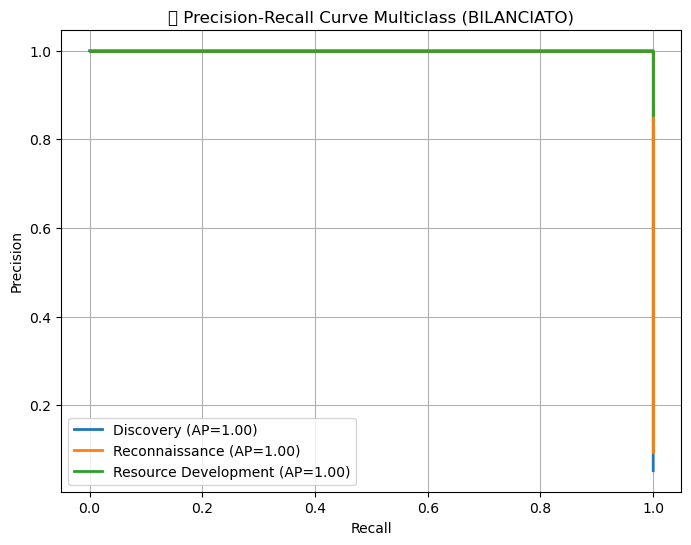

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


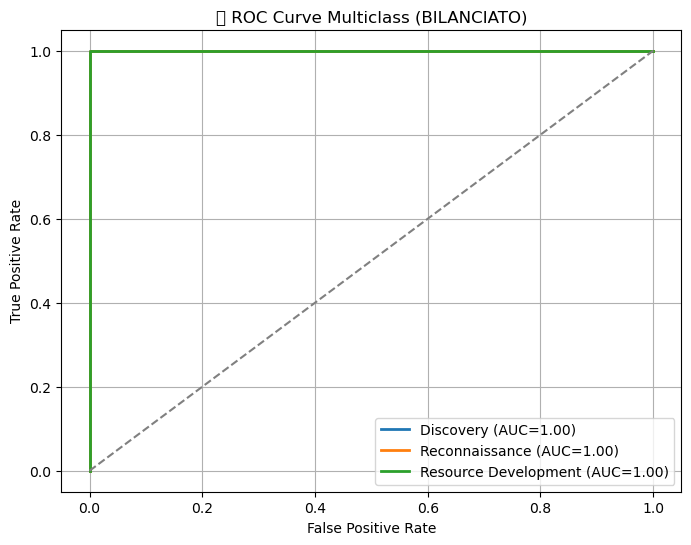

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


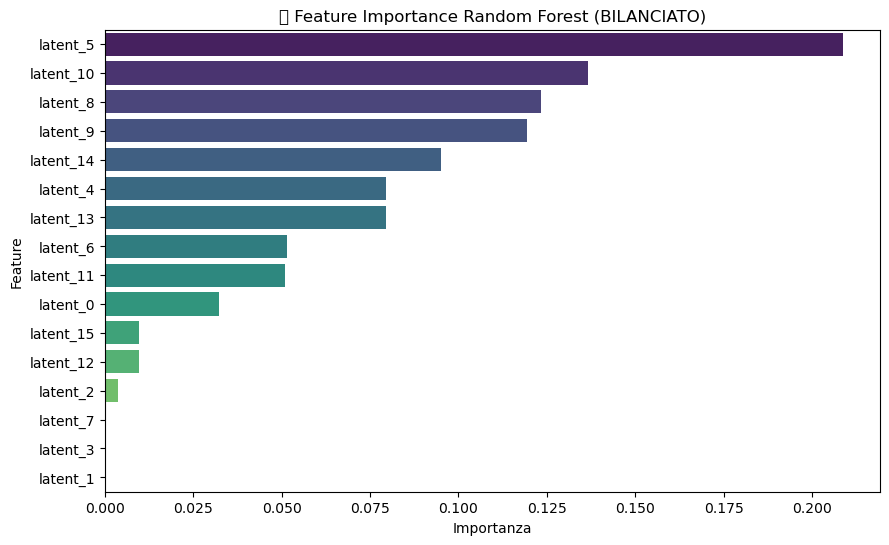


✅ Tutti i grafici e metriche avanzate generati con successo!


In [16]:
# ==========================================================
# BLOCCO 2b ✅ Metriche avanzate, grafici e feature importance
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
import numpy as np

print("📊 Generazione grafici e visualizzazioni avanzate per Random Forest bilanciata...\n")

# ==========================================================
# 1️⃣ Learning Curve
# ==========================================================
train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_train_bal, y_train_bal_str, cv=3, scoring='f1_macro', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Train score", marker='o')
plt.plot(train_sizes, test_mean, label="Test score", marker='s')
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve Random Forest (BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 2️⃣ Confusion Matrix
# ==========================================================
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test_str, cmap='Blues', normalize='true')
plt.title("📊 Confusion Matrix Normalizzata (BILANCIATO)")
plt.show()

# ==========================================================
# 3️⃣ Precision-Recall Curve multiclass
# ==========================================================
y_test_bin = label_binarize(y_test_str, classes=classes_str)
y_score = best_rf.predict_proba(X_test)

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes_str):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{cls} (AP={ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Precision-Recall Curve Multiclass (BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 4️⃣ ROC Curve multiclass
# ==========================================================
plt.figure(figsize=(8,6))
for i, cls in enumerate(classes_str):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Multiclass (BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# 5️⃣ Feature Importance
# ==========================================================
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=importances[indices],
    y=[f'latent_{i}' for i in indices],
    palette="viridis"
)
plt.title("🌟 Feature Importance Random Forest (BILANCIATO)")
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.show()

print("\n✅ Tutti i grafici e metriche avanzate generati con successo!")


In [17]:
# ==========================================================
# BLOCCO 3 ✅ LightGBM (train bilanciato) con monitoraggio fold per fold
# ==========================================================
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, 
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize

import lightgbm as lgb

print("🏗️ Addestramento LightGBM (TRAIN BILANCIATO) con monitoraggio dettagliato...\n")

# ==========================================================
# 1️⃣ Impostazione base del modello e della griglia iperparametri
# ==========================================================
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [10, -1],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50, 100]
}

param_combinations = list(product(
    param_grid['num_leaves'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['n_estimators']
))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_score = -np.inf
best_params = None
results = []

print(f"🔍 Inizio GridSearch manuale su {len(param_combinations)} combinazioni...\n")

# ==========================================================
# 2️⃣ Ciclo combinazioni e monitoraggio training fold per fold
# ==========================================================
for i, (num_leaves, max_depth, lr, n_est) in enumerate(param_combinations, 1):
    params = {
        'num_leaves': num_leaves,
        'max_depth': max_depth,
        'learning_rate': lr,
        'n_estimators': n_est,
        'random_state': 42
    }
    print(f"⚙️ Combinazione {i}/{len(param_combinations)} → {params}")
    start = time.time()
    
    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_bal, y_train_bal_enc), 1):
        X_tr, X_val = X_train_bal[train_idx], X_train_bal[val_idx]
        y_tr, y_val = y_train_bal_enc[train_idx], y_train_bal_enc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, average='macro')
        fold_scores.append(score)
        print(f"   📈 Fold {fold}/5 → F1 = {score:.4f}")

    mean_score = np.mean(fold_scores)
    elapsed = time.time() - start
    print(f"✅ Combinazione {i} completata in {elapsed:.2f}s | F1 medio = {mean_score:.4f}\n")

    results.append((params, mean_score))
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"🏁 GridSearch completata. Miglior F1 = {best_score:.4f}")
print(f"🏆 Migliori iperparametri trovati: {best_params}\n")

# ==========================================================
# 3️⃣ Training finale con i migliori parametri
# ==========================================================
best_lgb = lgb.LGBMClassifier(**best_params)
best_lgb.fit(X_train_bal, y_train_bal_enc)

# ==========================================================
# 4️⃣ Metriche dettagliate (train e test)
# ==========================================================
def print_metrics(y_true, y_pred, name, classes):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n📊 Metriche sul {name} set:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    for i, cls in enumerate(classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Specificità classe '{cls}': {spec:.4f}")
    return f1

y_train_pred = best_lgb.predict(X_train_bal)
y_test_pred = best_lgb.predict(X_test)

train_f1 = print_metrics(y_train_bal_enc, y_train_pred, "TRAIN", best_lgb.classes_)
test_f1 = print_metrics(y_test_enc, y_test_pred, "TEST", best_lgb.classes_)

# ==========================================================
# 5️⃣ Analisi over/underfitting
# ==========================================================
gap_f1 = train_f1 - test_f1
if gap_f1 > 0.05:
    print(f"\n⚠️ Possibile OVERFITTING: gap F1 train-test = {gap_f1:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile UNDERFITTING: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato, nessun evidente overfitting/underfitting")


🏗️ Addestramento LightGBM (TRAIN BILANCIATO) con monitoraggio dettagliato...

🔍 Inizio GridSearch manuale su 16 combinazioni...

⚙️ Combinazione 1/16 → {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 50, 'random_state': 42}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 13
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 1/5 → F1 = 0.9997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 2/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 3/5 → F1 = 0.9999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 4/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 5/5 → F1 = 0.9996
✅ Combinazione 1 completata in 3.36s | F1 medio = 0.9998

⚙️ Combinazione 2/16 → {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 100, 'random_state': 42}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 13
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 1/5 → F1 = 0.9997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 2/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 4/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 5/5 → F1 = 0.9995
✅ Combinazione 2 completata in 3.18s | F1 medio = 0.9998

⚙️ Combinazione 3/16 → {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 13
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 1/5 → F1 = 0.9997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 2/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 4/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 5/5 → F1 = 0.9996
✅ Combinazione 3 completata in 1.91s | F1 medio = 0.9998

⚙️ Combinazione 4/16 → {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 42}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 13
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 1/5 → F1 = 0.9997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 5/5 → F1 = 0.9996
✅ Combinazione 4 completata in 3.14s | F1 medio = 0.9998

⚙️ Combinazione 5/16 → {'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 50, 'random_state': 42}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 13
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 1/5 → F1 = 0.9997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 2/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 3/5 → F1 = 0.9999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 4/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 5/5 → F1 = 0.9996
✅ Combinazione 5 completata in 1.68s | F1 medio = 0.9998

⚙️ Combinazione 6/16 → {'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 100, 'random_state': 42}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 13
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 1/5 → F1 = 0.9997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 2/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 3/5 → F1 = 0.9999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 4/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 5/5 → F1 = 0.9995
✅ Combinazione 6 completata in 3.11s | F1 medio = 0.9998

⚙️ Combinazione 7/16 → {'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 13
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 1/5 → F1 = 0.9997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 2/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 3/5 → F1 = 0.9999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 4/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 5/5 → F1 = 0.9996
✅ Combinazione 7 completata in 1.72s | F1 medio = 0.9998

⚙️ Combinazione 8/16 → {'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 42}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 13
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
   📈 Fold 2/5 → F1 = 1.00

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 1/5 → F1 = 0.9997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 4/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 5/5 → F1 = 0.9996
✅ Combinazione 9 completata in 2.07s | F1 medio = 0.9998

⚙️ Combinazione 10/16 → {'num_leaves': 50, 'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 100, 'random_state': 42}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 13
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 1/5 → F1 = 0.9997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 2/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 3/5 → F1 = 0.9999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 5/5 → F1 = 0.9995
✅ Combinazione 10 completata in 3.88s | F1 medio = 0.9998

⚙️ Combinazione 11/16 → {'num_leaves': 50, 'max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 13
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 3/5 → F1 = 0.9999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 4/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 1/5 → F1 = 0.9997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 2/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 3/5 → F1 = 0.9999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 4/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 5/5 → F1 = 0.9996
✅ Combinazione 13 completata in 2.78s | F1 medio = 0.9998

⚙️ Combinazione 14/16 → {'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.05, 'n_estimators': 100, 'random_state': 42}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 13
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 1/5 → F1 = 0.9997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 2/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 3/5 → F1 = 0.9999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 4/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 5/5 → F1 = 0.9995
✅ Combinazione 14 completata in 4.53s | F1 medio = 0.9998

⚙️ Combinazione 15/16 → {'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 13
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 1/5 → F1 = 0.9997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 2/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 3/5 → F1 = 0.9999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 4/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 5/5 → F1 = 0.9996
✅ Combinazione 15 completata in 2.39s | F1 medio = 0.9998

⚙️ Combinazione 16/16 → {'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 42}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 13
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 1/5 → F1 = 0.9997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 2/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 30758, number of used features: 14
[LightGBM] [Info] Start training from score -1.098677
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Info] Start training from score -1.098580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 4/5 → F1 = 1.0000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 30759, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   📈 Fold 5/5 → F1 = 0.9996
✅ Combinazione 16 completata in 5.28s | F1 medio = 0.9998

🏁 GridSearch completata. Miglior F1 = 0.9998
🏆 Migliori iperparametri trovati: {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 42}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3325
[LightGBM] [Info] Number of data points in the train set: 38448, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



📊 Metriche sul TRAIN set:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-score:  1.0000
Specificità classe '0': 1.0000
Specificità classe '1': 1.0000
Specificità classe '2': 1.0000

📊 Metriche sul TEST set:
Accuracy:  1.0000
Precision: 0.9998
Recall:    0.9999
F1-score:  0.9999
Specificità classe '0': 1.0000
Specificità classe '1': 1.0000
Specificità classe '2': 1.0000

✅ Modello bilanciato, nessun evidente overfitting/underfitting



📊 Generazione grafici e visualizzazioni...


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


<Figure size 800x600 with 0 Axes>

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


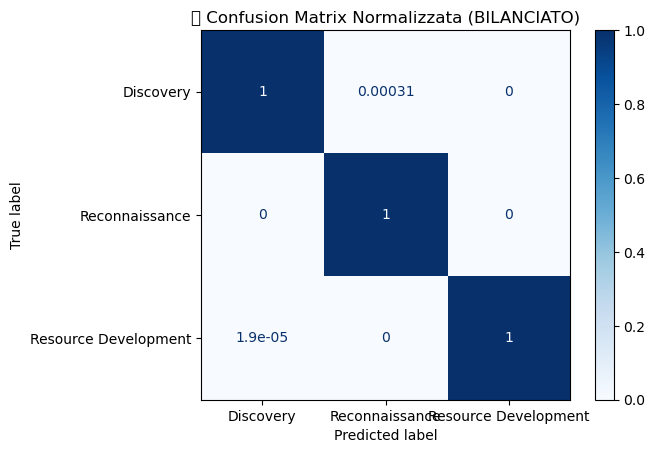

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


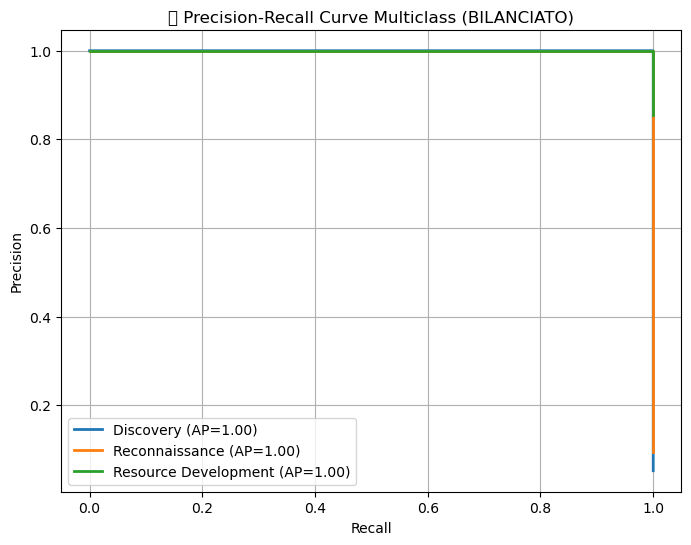

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


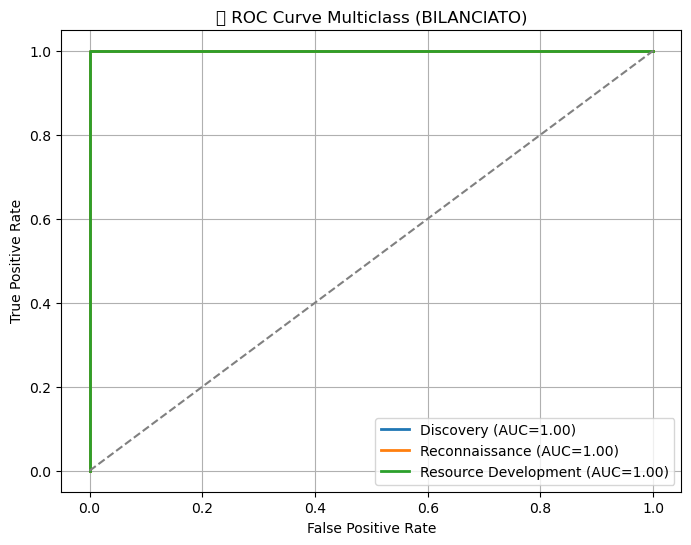

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


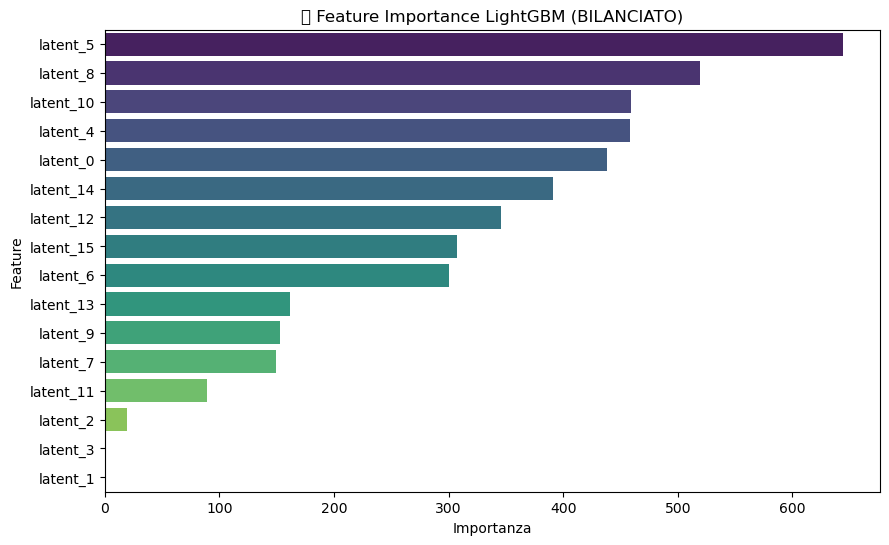


✅ Addestramento LightGBM completato con successo!


In [20]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, 
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize

import lightgbm as lgb
# ==========================================================
# 7️⃣ Confusion Matrix, PR, ROC, Feature Importance
# ==========================================================
print("\n📊 Generazione grafici e visualizzazioni...")

# Definizione etichette leggibili (stesse del modello)
class_labels = ['Discovery', 'Reconnaissance', 'Resource Development']

# Confusion Matrix ✅
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(
    best_lgb,
    X_test,
    y_test_enc,
    cmap='Blues',
    normalize='true',
    display_labels=class_labels
)
plt.title("📊 Confusion Matrix Normalizzata (BILANCIATO)")
plt.show()

# ==========================================================
# Precision-Recall Curve con label leggibili
# ==========================================================
# y_test_bin serve in formato numerico coerente con le classi del modello
y_test_bin = label_binarize(y_test_enc, classes=best_lgb.classes_)
y_score = best_lgb.predict_proba(X_test)

plt.figure(figsize=(8,6))
for i, cls in enumerate(class_labels):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{cls} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Precision-Recall Curve Multiclass (BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# ROC Curve con label leggibili
# ==========================================================
plt.figure(figsize=(8,6))
for i, cls in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Multiclass (BILANCIATO)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# Feature Importance
# ==========================================================
importances = best_lgb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
sns.barplot(
    x=importances[indices],
    y=[f'latent_{i}' for i in indices],
    palette="viridis"
)
plt.title("🌟 Feature Importance LightGBM (BILANCIATO)")
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.show()

print("\n✅ Addestramento LightGBM completato con successo!")
